<h1 align="center"> <strong>🌲 Random Forest - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to Random Forest, covering:
- Conceptual foundation and ensemble learning
- Implementation from scratch (simplified)
- Scikit-learn implementation
- Model evaluation and interpretation
- Feature importance and out-of-bag scoring
- Comparison with Decision Trees

---

## **📚 1. Import Libraries and Setup**

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.datasets import make_classification, make_regression, load_wine, load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve , GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
        mean_squared_error, r2_score, mean_absolute_error,precision_score, recall_score, f1_score , roc_curve, auc
)

# Statistical analysis
from scipy.stats import randint

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **🧠 2. Conceptual Foundation**

### **What is Random Forest?** 🤔

Random Forest is an **ensemble learning method** that combines multiple decision trees to create a more robust and accurate model. It uses two key techniques:

1. **Bootstrap Aggregating (Bagging)**: Train each tree on a different subset of the data
2. **Random Feature Selection**: Each tree considers only a random subset of features at each split

### **How Random Forest Works:**

1. **Bootstrap Sampling**: Create multiple bootstrap samples from the training data
2. **Random Feature Selection**: For each tree, randomly select a subset of features
3. **Train Multiple Trees**: Train a decision tree on each bootstrap sample
4. **Aggregate Predictions**: 
   - **Classification**: Majority voting
   - **Regression**: Average predictions

### **Key Concepts:**

- **Bagging**: Bootstrap Aggregating reduces variance
- **Out-of-Bag (OOB) Error**: Use unused samples for validation
- **Feature Importance**: Average importance across all trees
- **Wisdom of Crowds**: Many weak learners create a strong learner

### **Mathematical Foundation:**

#### Bootstrap Sampling:
For dataset $D$ with $n$ samples, create $B$ bootstrap samples $D_1, D_2, ..., D_B$ by sampling with replacement.

#### Random Forest Prediction:
**Classification:**
$$\hat{y} = \text{mode}\{h_1(x), h_2(x), ..., h_B(x)\}$$

**Regression:**
$$\hat{y} = \frac{1}{B} \sum_{i=1}^{B} h_i(x)$$

#### Out-of-Bag Error:
$$\text{OOB Error} = \frac{1}{n} \sum_{i=1}^{n} L(y_i, \hat{y}_i^{OOB})$$

Where $\hat{y}_i^{OOB}$ is the prediction for sample $i$ using only trees that didn't include $i$ in training.

### **Why Random Forest Works:**

1. **Reduces Overfitting**: Averaging reduces variance
2. **Handles Missing Values**: Can work with incomplete data
3. **Feature Importance**: Provides feature rankings
4. **Parallel Training**: Trees can be trained independently
5. **Robust to Outliers**: Averaging reduces impact of outliers

## **📊 3. Generate Sample Data**

🎯 Creating Classification Dataset
Classification dataset shape: (1000, 11)
Classes: [0 1]
Class distribution: [502 498]

📈 Creating Regression Dataset
Regression dataset shape: (800, 9)

🍷 Loading Wine Dataset
Wine dataset shape: (178, 13)
Classes  : ['class_0' 'class_1' 'class_2']
Features : 13


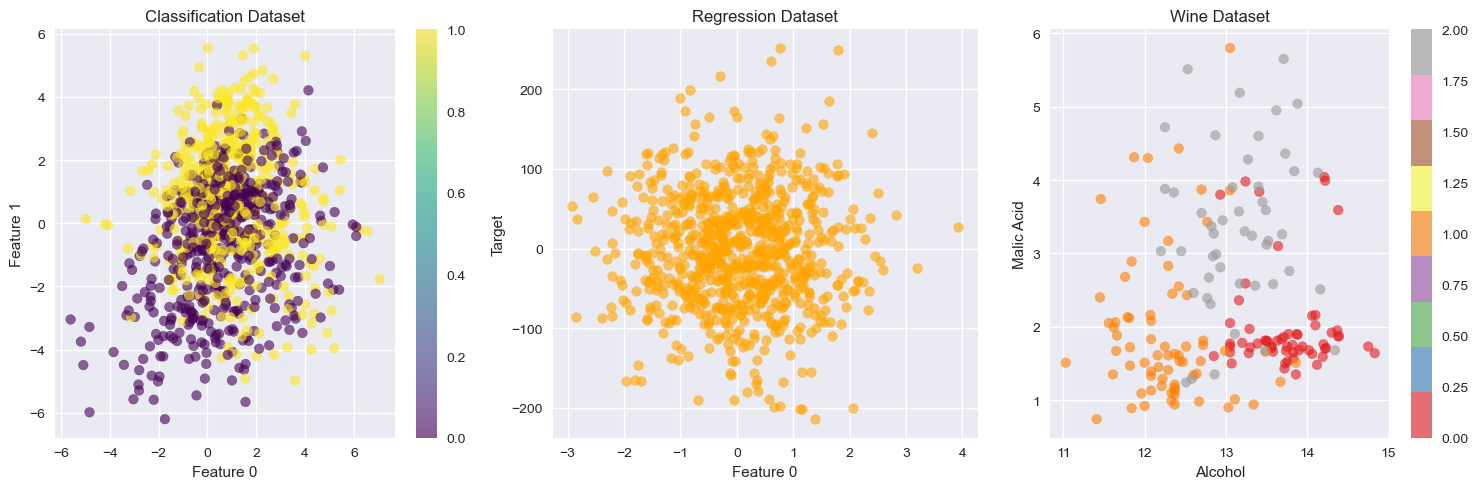

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Classification Dataset with more complexity
print("🎯 Creating Classification Dataset")
X_cls, y_cls = make_classification(n_samples=1000,n_features=10,n_informative=5,n_redundant=3,n_clusters_per_class=2,random_state=42)

# Add feature names
feature_names_cls = [f'feature_{i}' for i in range(X_cls.shape[1])]
df_cls = pd.DataFrame(X_cls, columns=feature_names_cls)
df_cls['target'] = y_cls

print(f"Classification dataset shape: {df_cls.shape}")
print(f"Classes: {np.unique(y_cls)}")
print(f"Class distribution: {np.bincount(y_cls)}")

# Regression Dataset
print("\n📈 Creating Regression Dataset")
X_reg, y_reg = make_regression(n_samples=800,n_features=8,n_informative=5,noise=15,random_state=42)

feature_names_reg = [f'feature_{i}' for i in range(X_reg.shape[1])]
df_reg = pd.DataFrame(X_reg, columns=feature_names_reg)
df_reg['target'] = y_reg

print(f"Regression dataset shape: {df_reg.shape}")

# Load real datasets for comparison
print("\n🍷 Loading Wine Dataset")
wine   = load_wine()
X_wine = wine.data
y_wine = wine.target

print(f"Wine dataset shape: {X_wine.shape}")
print(f"Classes  : {wine.target_names}")
print(f"Features : {len(wine.feature_names)}")

# Visualize some relationships
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_cls['feature_0'], df_cls['feature_1'], c=y_cls, cmap='viridis', alpha=0.6)
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.title('Classification Dataset')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.scatter(df_reg['feature_0'], df_reg['target'], alpha=0.6, color='orange')
plt.xlabel('Feature 0')
plt.ylabel('Target')
plt.title('Regression Dataset')

plt.subplot(1, 3, 3)
plt.scatter(X_wine[:, 0], X_wine[:, 1], c=y_wine, cmap='Set1', alpha=0.6)
plt.xlabel('Alcohol')
plt.ylabel('Malic Acid')
plt.title('Wine Dataset')
plt.colorbar()

plt.tight_layout()
plt.show()

## **🔧 4. Random Forest from Scratch (Simplified)**

In [5]:
class RandomForestScratch:
    """
    Simplified Random Forest implementation for binary classification
    """
    
    def __init__(self, n_estimators=10, max_depth=3, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
    
    def _bootstrap_sample(self, X, y):
        """Create bootstrap sample"""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices], indices
    
    def _get_random_features(self, n_features):
        """Get random subset of features"""
        if self.max_features == 'sqrt':
            max_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            max_features = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            max_features = self.max_features
        else:
            max_features = n_features
        
        return np.random.choice(n_features, max_features, replace=False)
    
    def fit(self, X, y):
        """Train the random forest"""
        if self.random_state:
            np.random.seed(self.random_state)
        
        X = np.array(X)
        y = np.array(y)
        n_samples, n_features = X.shape
        
        # Track feature usage for importance calculation
        feature_usage = np.zeros(n_features)
        
        for i in range(self.n_estimators):
            # Create bootstrap sample
            X_sample, y_sample, sample_indices = self._bootstrap_sample(X, y)
            
            # Get random features
            feature_indices = self._get_random_features(n_features)
            feature_usage[feature_indices] += 1
            
            # Create and train tree with random features
            tree = DecisionTreeClassifier(max_depth=self.max_depth,random_state=self.random_state + i if self.random_state else None)
            
            # Train tree on selected features only
            tree.fit(X_sample[:, feature_indices], y_sample)
            
            # Store tree and its feature indices
            self.trees.append({
                'tree': tree,
                'features': feature_indices,
                'sample_indices': sample_indices
            })
        
        # Calculate simple feature importance based on usage
        self.feature_importances_ = feature_usage / self.n_estimators
        return self
    
    def predict(self, X):
        """Make predictions using majority voting"""
        X = np.array(X)
        predictions = []
        
        for tree_info in self.trees:
            tree = tree_info['tree']
            features = tree_info['features']
            pred = tree.predict(X[:, features])
            predictions.append(pred)
        
        # Majority voting
        predictions = np.array(predictions).T
        return np.array([np.bincount(row).argmax() for row in predictions])
    
    def predict_proba(self, X):
        """Predict class probabilities"""
        X = np.array(X)
        n_samples = X.shape[0]
        n_classes = 2  # Simplified for binary classification
        
        probabilities = np.zeros((n_samples, n_classes))
        
        for tree_info in self.trees:
            tree = tree_info['tree']
            features = tree_info['features']
            proba = tree.predict_proba(X[:, features])
            probabilities += proba
        
        return probabilities / self.n_estimators

# Test our implementation
print("🌲 Testing Random Forest from Scratch")

# Use only first 2 features for simplicity
X_simple = X_cls[:, :2]
y_simple = y_cls

X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

# Train our Random Forest
rf_scratch = RandomForestScratch(n_estimators=10, max_depth=3, random_state=42)
rf_scratch.fit(X_train, y_train)

# Make predictions
y_pred_scratch = rf_scratch.predict(X_test)

print(f"Accuracy (Scratch)   : {accuracy_score(y_test, y_pred_scratch):.3f}")
print(f"Feature Importances  : {rf_scratch.feature_importances_}")

# Compare with single decision tree
tree_single = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_single.fit(X_train, y_train)
y_pred_single = tree_single.predict(X_test)

print(f"Single Tree Accuracy : {accuracy_score(y_test, y_pred_single):.3f}")
print(f"Random Forest shows {'improvement' if accuracy_score(y_test, y_pred_scratch) > accuracy_score(y_test, y_pred_single) else 'similar performance'}")

🌲 Testing Random Forest from Scratch
Accuracy (Scratch)   : 0.630
Feature Importances  : [0.5 0.5]
Single Tree Accuracy : 0.630
Random Forest shows similar performance


## **🛠️ 5. Scikit-learn Implementation - Classification**

In [32]:
# Classification with Wine dataset
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=0.3, random_state=42, stratify=y_wine)

# Create Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',random_state=42,oob_score=True )

# Train the model
rf_clf.fit(X_train_wine, y_train_wine)

# Make predictions
y_train_pred = rf_clf.predict(X_train_wine)
y_test_pred  = rf_clf.predict(X_test_wine)
y_test_proba = rf_clf.predict_proba(X_test_wine)

print("🎯 Random Forest Classification Results:")
print(f"Training Accuracy : {accuracy_score(y_train_wine, y_train_pred):.3f}")
print(f"Testing  Accuracy : {accuracy_score(y_test_wine, y_test_pred):.3f}")
print(f"OOB Score         : {rf_clf.oob_score_:.3f}")

print(f"\nPrecision : {precision_score(y_test_wine, y_test_pred, average='weighted'):.3f}")
print(f"Recall    : {recall_score(y_test_wine, y_test_pred, average='weighted'):.3f}")
print(f"F1-Score  : {f1_score(y_test_wine, y_test_pred, average='weighted'):.3f}")

# Compare with single Decision Tree
tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
tree_clf.fit(X_train_wine, y_train_wine)
tree_test_pred = tree_clf.predict(X_test_wine)

print(f"\n🌳 Single Decision Tree Accuracy: {accuracy_score(y_test_wine, tree_test_pred):.3f}")
print(f"🌲 Random Forest Improvement: {accuracy_score(y_test_wine, y_test_pred) - accuracy_score(y_test_wine, tree_test_pred):+.3f}")

print("\n📊 Top 10 Feature Importances:")
feature_importance_df = pd.DataFrame({
    'Feature': wine.feature_names,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

display(feature_importance_df.head(10))

print("\n📋 Classification Report:")
print(classification_report(y_test_wine, y_test_pred, target_names=wine.target_names))

🎯 Random Forest Classification Results:
Training Accuracy : 1.000
Testing  Accuracy : 1.000
OOB Score         : 0.976

Precision : 1.000
Recall    : 1.000
F1-Score  : 1.000

🌳 Single Decision Tree Accuracy: 0.963
🌲 Random Forest Improvement: +0.037

📊 Top 10 Feature Importances:


,Feature,Importance
0,alcohol,0.167689
9,color_intensity,0.165350
6,flavanoids,0.157735
12,proline,0.128711
10,hue,0.101290
11,od280/od315_of_diluted_wines,0.097816
5,total_phenols,0.038129
4,magnesium,0.031582
3,alcalinity_of_ash,0.031569
1,malic_acid,0.029928



📋 Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        18
     class_1       1.00      1.00      1.00        21
     class_2       1.00      1.00      1.00        15

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



## **📈 6. Scikit-learn Implementation - Regression**

In [20]:
# Regression with synthetic dataset
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Create Random Forest regressor
rf_reg = RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_split=5,min_samples_leaf=2,max_features='sqrt',random_state=42,oob_score=True)

# Train the model
rf_reg.fit(X_train_reg, y_train_reg)

# Make predictions
y_train_pred_reg = rf_reg.predict(X_train_reg)
y_test_pred_reg  = rf_reg.predict(X_test_reg)

print("📈 Random Forest Regression Results:")
print(f"Training R² Score : {r2_score(y_train_reg, y_train_pred_reg):.3f}")
print(f"Testing  R² Score : {r2_score(y_test_reg, y_test_pred_reg):.3f}")
print(f"OOB Score         : {rf_reg.oob_score_:.3f}\n")

print(f"Training RMSE : {np.sqrt(mean_squared_error(y_train_reg, y_train_pred_reg)):.3f}")
print(f"Testing  RMSE : {np.sqrt(mean_squared_error(y_test_reg, y_test_pred_reg)):.3f}")
print(f"Testing  MAE  : {mean_absolute_error(y_test_reg, y_test_pred_reg):.3f}")

# Compare with single Decision Tree
tree_reg = DecisionTreeRegressor(max_depth=10, random_state=42)
tree_reg.fit(X_train_reg, y_train_reg)
tree_test_pred_reg = tree_reg.predict(X_test_reg)

print(f"\n🌳 Single Decision Tree R²   : {r2_score(y_test_reg, tree_test_pred_reg):.3f}")
print(f"🌲 Random Forest Improvement : {r2_score(y_test_reg, y_test_pred_reg) - r2_score(y_test_reg, tree_test_pred_reg):+.3f}")

print("\n📊 Feature Importances (Regression):")
reg_importance_df = pd.DataFrame({
    'Feature': feature_names_reg,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

display(reg_importance_df)

📈 Random Forest Regression Results:
Training R² Score : 0.949
Testing  R² Score : 0.845
OOB Score         : 0.839

Training RMSE : 16.540
Testing  RMSE : 25.959
Testing  MAE  : 19.808

🌳 Single Decision Tree R²   : 0.804
🌲 Random Forest Improvement : +0.041

📊 Feature Importances (Regression):


,Feature,Importance
2,feature_2,0.637812
4,feature_4,0.120881
5,feature_5,0.066580
1,feature_1,0.046796
6,feature_6,0.033957
3,feature_3,0.033931
0,feature_0,0.031532
7,feature_7,0.028509


## **📊 7. Comprehensive Visualizations**

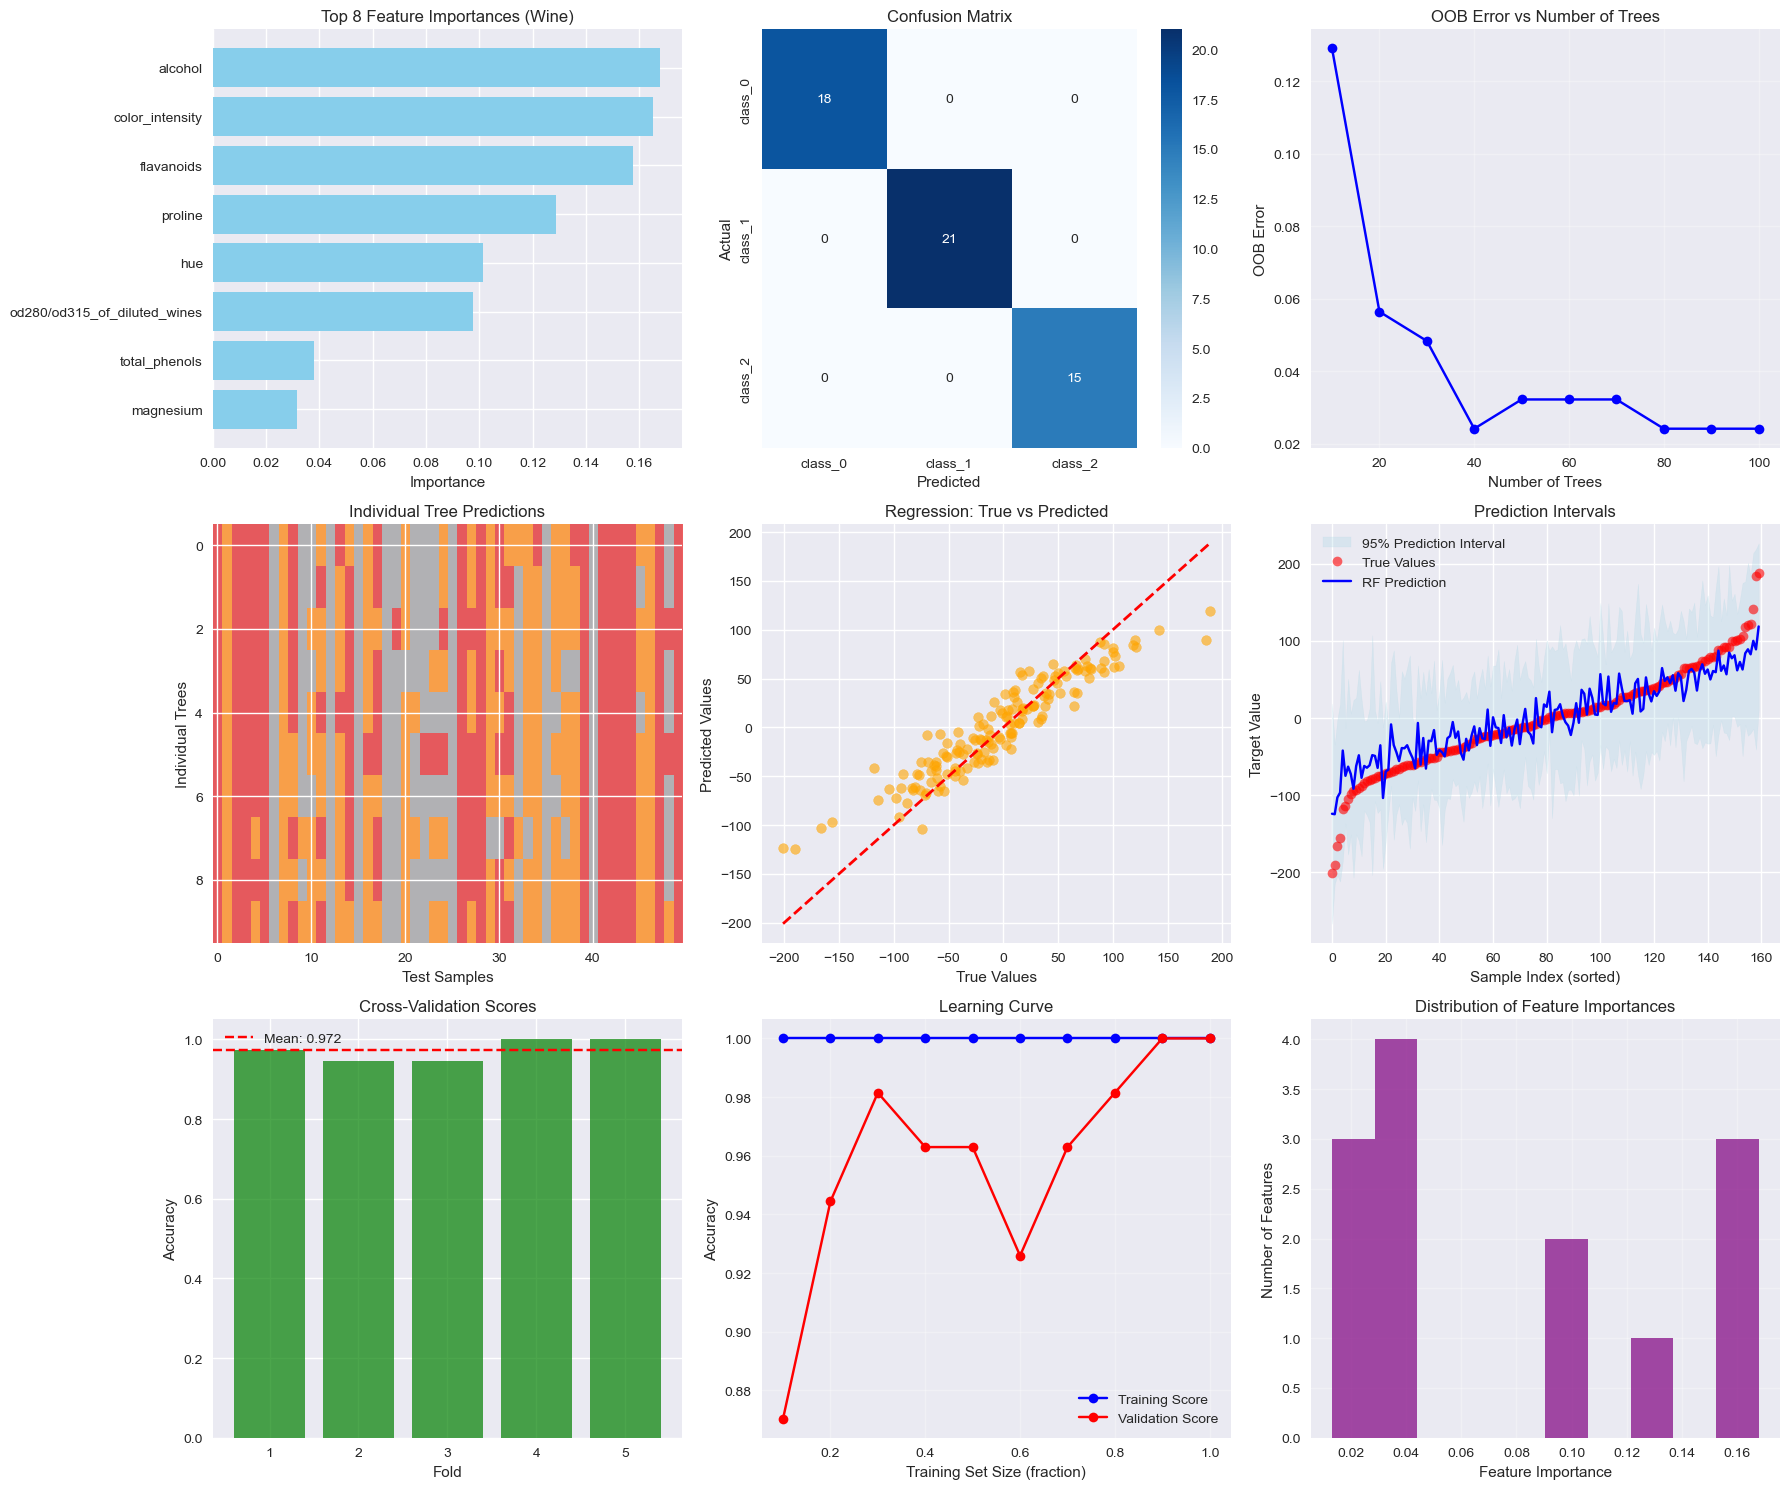

📊 Cross-Validation Results:
CV Scores     : [0.97222222 0.94444444 0.94444444 1.         1.        ]
Mean CV Score : 0.972 (+/- 0.050)


In [22]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 1. Feature Importance Comparison (Classification)
top_features = feature_importance_df.head(8)
axes[0, 0].barh(top_features['Feature'], top_features['Importance'], color='skyblue')
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 8 Feature Importances (Wine)')
axes[0, 0].invert_yaxis()

# 2. Confusion Matrix
cm = confusion_matrix(y_test_wine, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],xticklabels=wine.target_names, yticklabels=wine.target_names)
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Confusion Matrix')

# 3. OOB Error vs Number of Trees
n_estimators_range = range(10, 101, 10)
oob_errors = []

for n_est in n_estimators_range:
    rf_temp = RandomForestClassifier(n_estimators=n_est, random_state=42, oob_score=True)
    rf_temp.fit(X_train_wine, y_train_wine)
    oob_errors.append(1 - rf_temp.oob_score_)

axes[0, 2].plot(n_estimators_range, oob_errors, 'b-', marker='o')
axes[0, 2].set_xlabel('Number of Trees')
axes[0, 2].set_ylabel('OOB Error')
axes[0, 2].set_title('OOB Error vs Number of Trees')
axes[0, 2].grid(True, alpha=0.3)

# 4. Individual Tree Predictions vs Ensemble
# Show predictions for first 50 test samples
n_show = 50
individual_preds = []
for estimator in rf_clf.estimators_[:10]:  # Show first 10 trees
    pred = estimator.predict(X_test_wine[:n_show])
    individual_preds.append(pred)

individual_preds = np.array(individual_preds)
ensemble_pred = rf_clf.predict(X_test_wine[:n_show])

axes[1, 0].imshow(individual_preds, aspect='auto', cmap='Set1', alpha=0.7)
axes[1, 0].set_xlabel('Test Samples')
axes[1, 0].set_ylabel('Individual Trees')
axes[1, 0].set_title('Individual Tree Predictions')

# 5. Regression: True vs Predicted
axes[1, 1].scatter(y_test_reg, y_test_pred_reg, alpha=0.6, color='orange')
axes[1, 1].plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('True Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Regression: True vs Predicted')

# 6. Prediction Intervals (using tree predictions)
tree_predictions = np.array([tree.predict(X_test_reg) for tree in rf_reg.estimators_])
pred_mean = np.mean(tree_predictions, axis=0)
pred_std = np.std(tree_predictions, axis=0)

# Sort by true values for better visualization
sort_idx = np.argsort(y_test_reg)
axes[1, 2].fill_between(range(len(y_test_reg)), (pred_mean - 2*pred_std)[sort_idx],(pred_mean + 2*pred_std)[sort_idx],alpha=0.3, color='lightblue', label='95% Prediction Interval')
axes[1, 2].plot(y_test_reg[sort_idx], 'o', alpha=0.6, color='red', label='True Values')
axes[1, 2].plot(pred_mean[sort_idx], '-', color='blue', label='RF Prediction')
axes[1, 2].set_xlabel('Sample Index (sorted)')
axes[1, 2].set_ylabel('Target Value')
axes[1, 2].set_title('Prediction Intervals')
axes[1, 2].legend()

# 7. Cross-validation scores
cv_scores = cross_val_score(rf_clf, X_wine, y_wine, cv=5, scoring='accuracy')
axes[2, 0].bar(range(1, 6), cv_scores, color='green', alpha=0.7)
axes[2, 0].axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
axes[2, 0].set_xlabel('Fold')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_title('Cross-Validation Scores')
axes[2, 0].legend()

# 8. Learning Curve: Performance vs Training Set Size
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_mean = []
test_scores_mean  = []

for train_size in train_sizes:
    n_samples = int(train_size * len(X_train_wine))
    rf_temp   = RandomForestClassifier(n_estimators=50, random_state=42)
    rf_temp.fit(X_train_wine[:n_samples], y_train_wine[:n_samples])
    
    train_score = rf_temp.score(X_train_wine[:n_samples], y_train_wine[:n_samples])
    test_score  = rf_temp.score(X_test_wine, y_test_wine)
    
    train_scores_mean.append(train_score)
    test_scores_mean.append(test_score)

axes[2, 1].plot(train_sizes, train_scores_mean, 'o-', label='Training Score', color='blue')
axes[2, 1].plot(train_sizes, test_scores_mean, 'o-', label='Validation Score', color='red')
axes[2, 1].set_xlabel('Training Set Size (fraction)')
axes[2, 1].set_ylabel('Accuracy')
axes[2, 1].set_title('Learning Curve')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

# 9. Feature Importance Distribution
axes[2, 2].hist(rf_clf.feature_importances_, bins=10, alpha=0.7, color='purple')
axes[2, 2].set_xlabel('Feature Importance')
axes[2, 2].set_ylabel('Number of Features')
axes[2, 2].set_title('Distribution of Feature Importances')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Cross-Validation Results:")
print(f"CV Scores     : {cv_scores}")
print(f"Mean CV Score : {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

## **⚖️ 8. Bias-Variance Analysis**

🎯 Bias-Variance Analysis


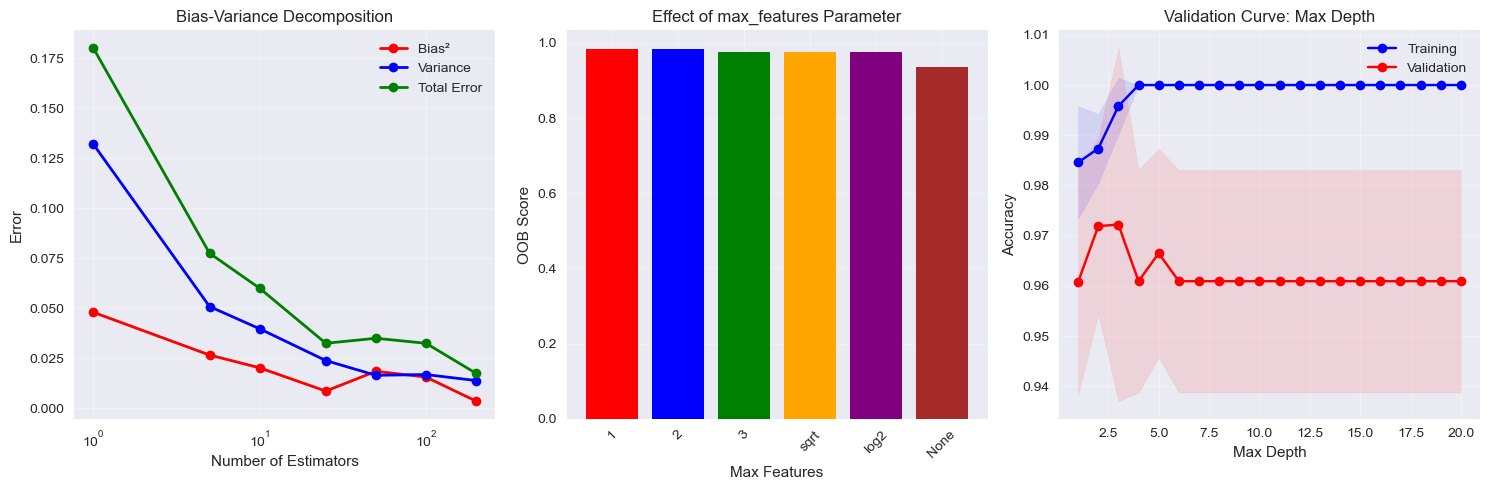

📊 Max Features Analysis:
1 : 0.984
2 : 0.984
3 : 0.976
sqrt : 0.976
log2 : 0.976
None : 0.935


In [26]:
# Analyze bias-variance tradeoff with number of estimators
print("🎯 Bias-Variance Analysis")

n_estimators_range = [1, 5, 10, 25, 50, 100, 200]
n_iterations       = 20
bias_values        = []
variance_values    = []
mse_values         = []

# Create a fixed test set
X_fixed_test = X_test_wine[:20]  # Use smaller set for computation
y_fixed_test = y_test_wine[:20]

for n_est in n_estimators_range:
    predictions = []
    
    # Run multiple iterations with different random states
    for iteration in range(n_iterations):
        # Create bootstrap sample for training
        indices = np.random.choice(len(X_train_wine), size=len(X_train_wine), replace=True)
        X_bootstrap = X_train_wine[indices]
        y_bootstrap = y_train_wine[indices]
        
        # Train Random Forest
        rf_temp = RandomForestClassifier(n_estimators=n_est, random_state=iteration)
        rf_temp.fit(X_bootstrap, y_bootstrap)
        
        # Get predictions (convert to numeric for bias-variance calculation)
        pred = rf_temp.predict(X_fixed_test)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Calculate mean prediction across all iterations
    mean_prediction = np.mean(predictions, axis=0)
    
    # Calculate bias² (squared difference between mean prediction and true value)
    bias_squared = np.mean((mean_prediction - y_fixed_test) ** 2)
    
    # Calculate variance (average squared difference from mean prediction)
    variance = np.mean(np.var(predictions, axis=0))
    
    # Calculate MSE
    mse = np.mean([np.mean((pred - y_fixed_test) ** 2) for pred in predictions])
    
    bias_values.append(bias_squared)
    variance_values.append(variance)
    mse_values.append(mse)

# Plot bias-variance decomposition
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(n_estimators_range, bias_values, 'r-o', label='Bias²', linewidth=2)
plt.plot(n_estimators_range, variance_values, 'b-o', label='Variance', linewidth=2)
plt.plot(n_estimators_range, mse_values, 'g-o', label='Total Error', linewidth=2)
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.title('Bias-Variance Decomposition')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

# Analyze effect of max_features
max_features_options = [1, 2, 3, 'sqrt', 'log2', None]
max_features_scores  = []

for max_feat in max_features_options:
    rf_temp = RandomForestClassifier(n_estimators=100, max_features=max_feat, random_state=42,oob_score=True)
    rf_temp.fit(X_train_wine, y_train_wine)
    max_features_scores.append(rf_temp.oob_score_)

plt.subplot(1, 3, 2)
plt.bar(range(len(max_features_options)), max_features_scores, 
        color=['red', 'blue', 'green', 'orange', 'purple', 'brown'])
plt.xlabel('Max Features')
plt.ylabel('OOB Score')
plt.title('Effect of max_features Parameter')
plt.xticks(range(len(max_features_options)), [str(x) for x in max_features_options], rotation=45)
plt.grid(True, alpha=0.3)

# Validation curve for max_depth
train_scores_depth, test_scores_depth = validation_curve(RandomForestClassifier(n_estimators=50, random_state=42), X_wine, y_wine,param_name='max_depth', param_range=range(1, 21),cv=5, scoring='accuracy')

plt.subplot(1, 3, 3)
plt.plot(range(1, 21), train_scores_depth.mean(axis=1), 'o-', label='Training', color='blue')
plt.plot(range(1, 21), test_scores_depth.mean(axis=1), 'o-', label='Validation', color='red')
plt.fill_between(range(1, 21), train_scores_depth.mean(axis=1) - train_scores_depth.std(axis=1),train_scores_depth.mean(axis=1) + train_scores_depth.std(axis=1),alpha=0.1, color='blue')
plt.fill_between(range(1, 21), test_scores_depth.mean(axis=1) - test_scores_depth.std(axis=1),test_scores_depth.mean(axis=1) + test_scores_depth.std(axis=1),alpha=0.1, color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Validation Curve: Max Depth')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Max Features Analysis:")
for i, (feat, score) in enumerate(zip(max_features_options, max_features_scores)):
    print(f"{feat} : {score:.3f}")

## **🎛️ 9. Hyperparameter Tuning and Optimization**

🎛️ Hyperparameter Tuning for Random Forest
🔍 Grid Search (limited parameters for demo)
Best parameters : {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
Best CV score   : 0.981

🎲 Random Search
Best parameters: {'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 8, 'n_estimators': 250}
Best CV score: 0.981

🏆 Final Model Performance:
Test Accuracy: 0.963
Default RF Accuracy: 1.000
Improvement: -0.037


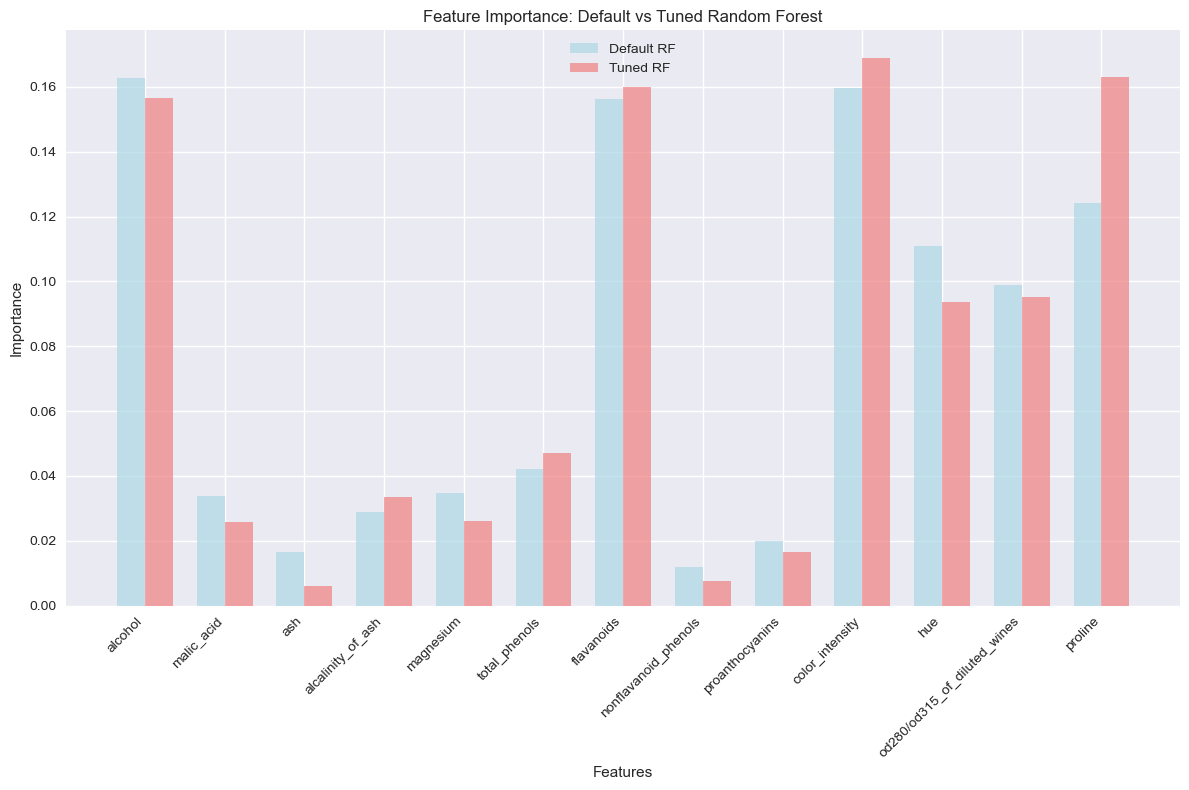

In [27]:
print("🎛️ Hyperparameter Tuning for Random Forest")

# Define parameter grid for Grid Search
param_grid = {
    'n_estimators'      : [50, 100, 200],
    'max_depth'         : [5, 10, 15, None],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf'  : [1, 2, 4],
    'max_features'      : ['sqrt', 'log2']
}

# Use a smaller dataset for faster computation
X_sample, _, y_sample, _ = train_test_split(X_wine, y_wine, train_size=0.3, random_state=42)

print("🔍 Grid Search (limited parameters for demo)")
# Limited grid search for demonstration
limited_param_grid = {
    'n_estimators'  : [50, 100],
    'max_depth'     : [5, 10],
    'max_features'  : ['sqrt', 'log2']
}

grid_search = GridSearchCV( RandomForestClassifier(random_state=42), limited_param_grid, cv=3, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_sample, y_sample)

print(f"Best parameters : {grid_search.best_params_}")
print(f"Best CV score   : {grid_search.best_score_:.3f}")

# Random Search (more efficient for larger parameter spaces)
print("\n🎲 Random Search")

random_param_dist = {
    'n_estimators'      : randint(50, 301),
    'max_depth'         : randint(3, 21),
    'min_samples_split' : randint(2, 21),
    'min_samples_leaf'  : randint(1, 11),
    'max_features'      : ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),random_param_dist,n_iter=20, cv=3,scoring='accuracy',random_state=42,n_jobs=-1)

random_search.fit(X_sample, y_sample)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.3f}")

# Train final model with best parameters
best_rf = RandomForestClassifier(**random_search.best_params_, random_state=42)
best_rf.fit(X_train_wine, y_train_wine)
best_predictions = best_rf.predict(X_test_wine)

print(f"\n🏆 Final Model Performance:")
print(f"Test Accuracy: {accuracy_score(y_test_wine, best_predictions):.3f}")

# Compare with default parameters
default_rf = RandomForestClassifier(random_state=42)
default_rf.fit(X_train_wine, y_train_wine)
default_predictions = default_rf.predict(X_test_wine)

print(f"Default RF Accuracy: {accuracy_score(y_test_wine, default_predictions):.3f}")
print(f"Improvement: {accuracy_score(y_test_wine, best_predictions) - accuracy_score(y_test_wine, default_predictions):+.3f}")

# Visualize parameter importance
feature_importance_comparison = pd.DataFrame({
    'Feature': wine.feature_names,
    'Default_RF': default_rf.feature_importances_,
    'Tuned_RF': best_rf.feature_importances_
})

plt.figure(figsize=(12, 8))
x = np.arange(len(wine.feature_names))
width = 0.35

plt.bar(x - width/2, default_rf.feature_importances_, width, label='Default RF', alpha=0.7, color='lightblue')
plt.bar(x + width/2, best_rf.feature_importances_, width, label='Tuned RF', alpha=0.7, color='lightcoral')

plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance: Default vs Tuned Random Forest')
plt.xticks(x, wine.feature_names, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## **📊 10. Out-of-Bag (OOB) Analysis**

📊 Out-of-Bag (OOB) Analysis
Final OOB  Score : 0.976
Final Test Score : 1.000
Difference       : 0.024
OOB Prediction Accuracy: 0.976


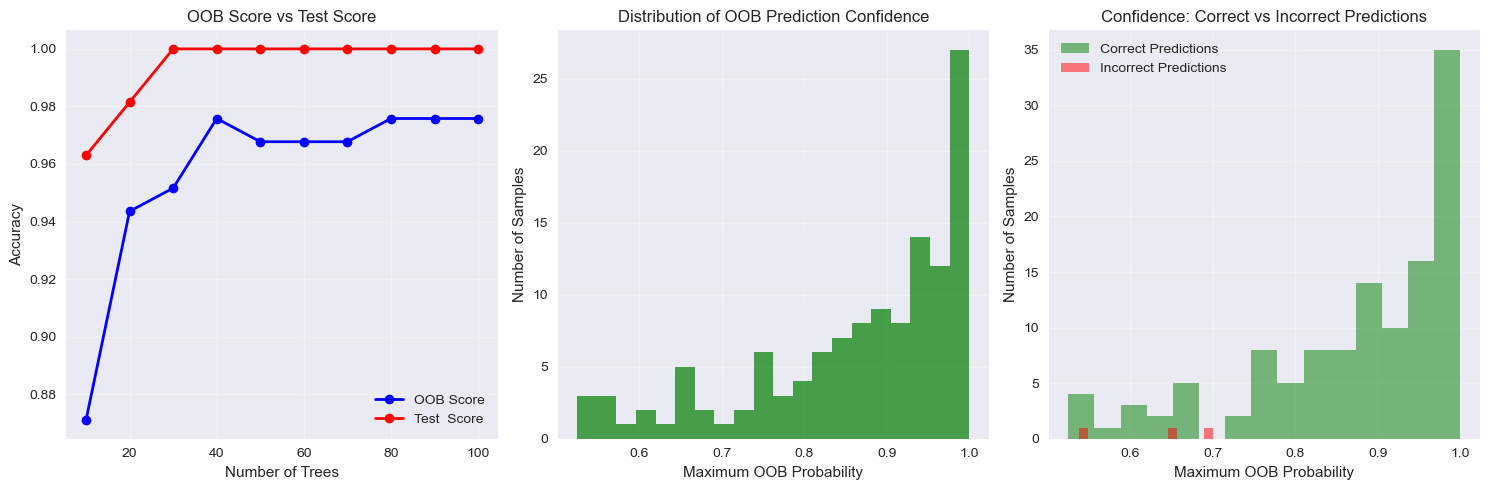

Average confidence for correct   predictions: 0.873
Average confidence for incorrect predictions: 0.631


In [36]:
print("📊 Out-of-Bag (OOB) Analysis")

# Create Random Forest with OOB scoring enabled
rf_oob = RandomForestClassifier(n_estimators=100,random_state=42,oob_score=True,warm_start=True )

# Track OOB score as we add more trees
oob_scores = []
n_trees_range = range(10, 101, 10)

for n_trees in n_trees_range:
    rf_oob.n_estimators = n_trees
    rf_oob.fit(X_train_wine, y_train_wine)
    oob_scores.append(rf_oob.oob_score_)

# Compare OOB score with test score
test_scores = []
for n_trees in n_trees_range:
    rf_temp = RandomForestClassifier(n_estimators=n_trees, random_state=42)
    rf_temp.fit(X_train_wine, y_train_wine)
    test_scores.append(rf_temp.score(X_test_wine, y_test_wine))

# Plot OOB vs Test scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(n_trees_range, oob_scores, 'b-o',  label='OOB Score', linewidth=2)
plt.plot(n_trees_range, test_scores, 'r-o', label='Test  Score', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('OOB Score vs Test Score')
plt.legend()
plt.grid(True, alpha=0.3)

print(f"Final OOB  Score : {rf_oob.oob_score_:.3f}")
print(f"Final Test Score : {rf_oob.score(X_test_wine, y_test_wine):.3f}")
print(f"Difference       : {abs(rf_oob.oob_score_ - rf_oob.score(X_test_wine, y_test_wine)):.3f}")

# OOB predictions and decision function
oob_predictions = rf_oob.oob_decision_function_
oob_predicted_classes = np.argmax(oob_predictions, axis=1)

# Compare OOB predictions with true labels
oob_accuracy = accuracy_score(y_train_wine, oob_predicted_classes)
print(f"OOB Prediction Accuracy: {oob_accuracy:.3f}")

# Visualize OOB prediction confidence
plt.subplot(1, 3, 2)
max_probs = np.max(oob_predictions, axis=1)
plt.hist(max_probs, bins=20, alpha=0.7, color='green')
plt.xlabel('Maximum OOB Probability')
plt.ylabel('Number of Samples')
plt.title('Distribution of OOB Prediction Confidence')
plt.grid(True, alpha=0.3)

# Analyze OOB errors
oob_errors = (oob_predicted_classes != y_train_wine)
error_probs = max_probs[oob_errors]
correct_probs = max_probs[~oob_errors]

plt.subplot(1, 3, 3)
plt.hist(correct_probs, bins=15, alpha=0.5, label='Correct Predictions', color='green')
plt.hist(error_probs, bins=15, alpha=0.5, label='Incorrect Predictions', color='red')
plt.xlabel('Maximum OOB Probability')
plt.ylabel('Number of Samples')
plt.title('Confidence: Correct vs Incorrect Predictions')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Average confidence for correct   predictions: {np.mean(correct_probs):.3f}")
print(f"Average confidence for incorrect predictions: {np.mean(error_probs):.3f}")

## **✅ 11. Advantages and Disadvantages**

### **Advantages:** ✅

1. **Reduced Overfitting**: Ensemble reduces variance compared to single trees
2. **High Accuracy**: Generally achieves better performance than single models
3. **Feature Importance**: Provides robust feature importance scores
4. **Handles Missing Values**: Can work with incomplete data
5. **Out-of-Bag Validation**: Built-in cross-validation through OOB scoring
6. **Parallel Training**: Trees can be trained independently
7. **Robust to Outliers**: Averaging reduces impact of outliers
8. **No Data Preprocessing**: Works with raw numerical and categorical data
9. **Handles Large Datasets**: Scales well with data size
10. **Stable**: Less sensitive to small changes in data

### **Disadvantages:** ❌

1. **Less Interpretable**: Harder to interpret than single decision trees
2. **Memory Usage**: Requires more memory to store multiple trees
3. **Overfitting with Noise**: Can still overfit with very noisy data
4. **Biased Feature Selection**: Still biased toward features with more levels
5. **Prediction Speed**: Slower prediction than single trees
6. **Black Box**: Less transparent than single tree models
7. **Hyperparameter Tuning**: More parameters to tune than simple models

### **When to Use Random Forest:** 🎯

- **High Accuracy Needed**: When you prioritize performance over interpretability
- **Mixed Data Types**: When you have both numerical and categorical features
- **Feature Selection**: When you need automatic feature importance ranking
- **Robust Models**: When you need stable, reliable predictions
- **Baseline Models**: As a strong baseline for more complex models
- **Limited Data Preprocessing**: When you want minimal data preparation

### **When NOT to Use:** ⚠️

- **Simple Linear Relationships**: When relationships are primarily linear
- **High Interpretability Required**: When you need to explain every decision(eg. Medical or legal fields)
- **Real-time Predictions**: When prediction speed is critical
- **Memory Constraints**: When memory usage is a major concern
- **Very Small Datasets**: When you have very limited training data

## **🆚 12. Random Forest vs Decision Trees Comparison**

🆚 Random Forest vs Decision Trees Comparison
📊 Model Comparison:
                       Model  Accuracy  Precision  Recall  F1-Score  CV Score
0       Decision Tree (Deep)     0.963      0.966   0.963     0.963     0.865
1     Decision Tree (Pruned)     0.963      0.966   0.963     0.963     0.877
2   Random Forest (50 trees)     1.000      1.000   1.000     1.000     0.961
3  Random Forest (100 trees)     1.000      1.000   1.000     1.000     0.972


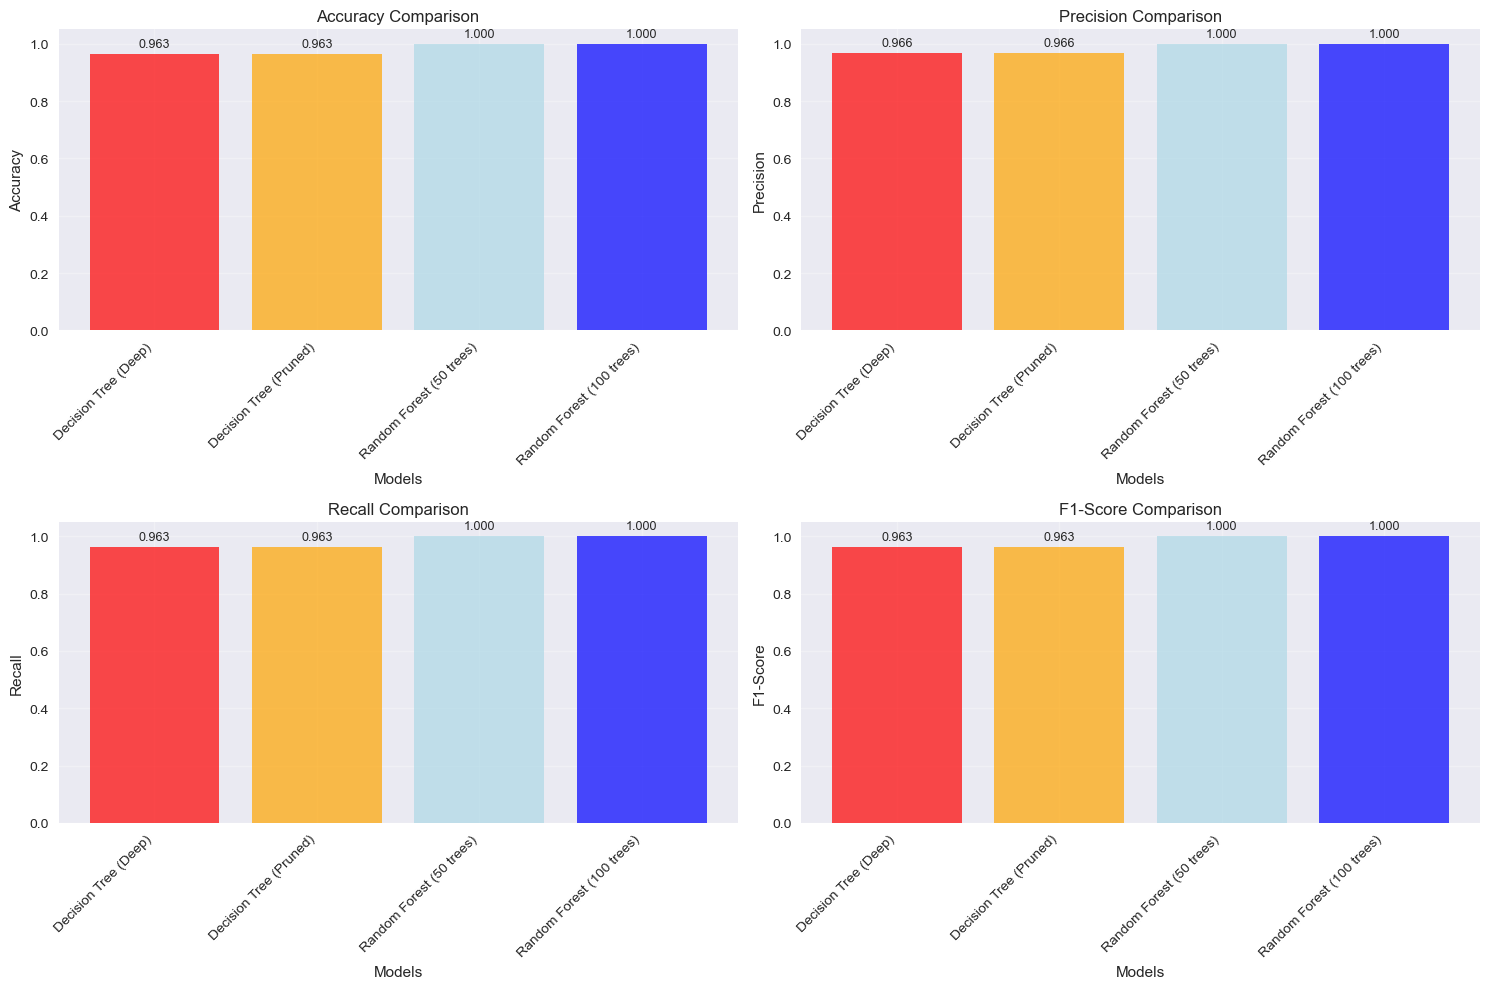


🎲 Stability Analysis:
Decision Tree - Mean Accuracy : 0.946 ± 0.031
Random Forest - Mean Accuracy : 0.987 ± 0.016
Random Forest shows higher accuracy
Random Forest shows lower variance


In [29]:
# Comprehensive comparison between Random Forest and Decision Trees
print("🆚 Random Forest vs Decision Trees Comparison")

# Create different models for comparison
models = {
    'Decision Tree (Deep)'      : DecisionTreeClassifier(random_state=42),
    'Decision Tree (Pruned)'    : DecisionTreeClassifier(max_depth=5, min_samples_split=10, random_state=42),
    'Random Forest (50 trees)'  : RandomForestClassifier(n_estimators=50, random_state=42),
    'Random Forest (100 trees)' : RandomForestClassifier(n_estimators=100, random_state=42)
}

# Compare performance across different metrics
results = []

for name, model in models.items():
    # Train model
    model.fit(X_train_wine, y_train_wine)
    
    # Get predictions
    y_pred = model.predict(X_test_wine)
    
    # Calculate metrics
    accuracy  = accuracy_score(y_test_wine, y_pred)
    precision = precision_score(y_test_wine, y_pred, average='weighted')
    recall    = recall_score(y_test_wine, y_pred, average='weighted')
    f1        = f1_score(y_test_wine, y_pred, average='weighted')
    
    # Cross-validation score
    cv_score = cross_val_score(model, X_wine, y_wine, cv=5).mean()
    
    results.append({
        'Model'     : name,
        'Accuracy'  : accuracy,
        'Precision' : precision,
        'Recall'    : recall,
        'F1-Score'  : f1,
        'CV Score'  : cv_score
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("📊 Model Comparison:")
print(comparison_df.round(3))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Score']
x_pos = np.arange(len(comparison_df))

for i, metric in enumerate(metrics[:4]):
    ax = axes[i//2, i%2]
    bars = ax.bar(x_pos, comparison_df[metric], color=['red', 'orange', 'lightblue', 'blue'], alpha=0.7)
    ax.set_xlabel('Models')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),  textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Stability Analysis: Train models multiple times with different random states
print("\n🎲 Stability Analysis:")
stability_results = []

for random_state in range(10):
    dt_scores = []
    rf_scores = []
    
    # Create bootstrap samples
    for _ in range(5):
        indices = np.random.choice(len(X_wine), size=len(X_wine), replace=True)
        X_bootstrap = X_wine[indices]
        y_bootstrap = y_wine[indices]
        
        # Split bootstrap sample
        X_train_boot, X_test_boot, y_train_boot, y_test_boot = train_test_split(X_bootstrap, y_bootstrap, test_size=0.3, random_state=42)
        
        # Train models
        dt = DecisionTreeClassifier(random_state=random_state)
        rf = RandomForestClassifier(n_estimators=50, random_state=random_state)
        
        dt.fit(X_train_boot, y_train_boot)
        rf.fit(X_train_boot, y_train_boot)
        
        dt_scores.append(dt.score(X_test_boot, y_test_boot))
        rf_scores.append(rf.score(X_test_boot, y_test_boot))
    
    stability_results.append({
        'DT_mean' : np.mean(dt_scores),
        'DT_std'  : np.std(dt_scores),
        'RF_mean' : np.mean(rf_scores),
        'RF_std'  : np.std(rf_scores)
    })

stability_df = pd.DataFrame(stability_results)

print(f"Decision Tree - Mean Accuracy : {stability_df['DT_mean'].mean():.3f} ± {stability_df['DT_std'].mean():.3f}")
print(f"Random Forest - Mean Accuracy : {stability_df['RF_mean'].mean():.3f} ± {stability_df['RF_std'].mean():.3f}")
print(f"Random Forest shows {'higher' if stability_df['RF_mean'].mean() > stability_df['DT_mean'].mean() else 'lower'} accuracy")
print(f"Random Forest shows {'lower' if stability_df['RF_std'].mean() < stability_df['DT_std'].mean() else 'higher'} variance")

## **🔍 13. Real-World Example: Medical Diagnosis**

🏥 Medical Diagnosis Example: Breast Cancer Classification
Dataset             : 569 patients, 30 features
Classes             : ['malignant' 'benign']
Class distribution  : [212 357]

First 5 patients:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0



🎯 Medical Diagnosis Results:
Accuracy             : 0.95
Precision            : 0.96
Recall (Sensitivity) : 0.96
Specificity          : 0.93

📊 Top 10 Most Important Features for Diagnosis:


,Feature,Importance
23,worst area,0.143090
27,worst concave points,0.131059
20,worst radius,0.100750
7,mean concave points,0.092185
2,mean perimeter,0.074319
0,mean radius,0.070306
22,worst perimeter,0.070081
6,mean concavity,0.057274
3,mean area,0.049342
26,worst concavity,0.033558


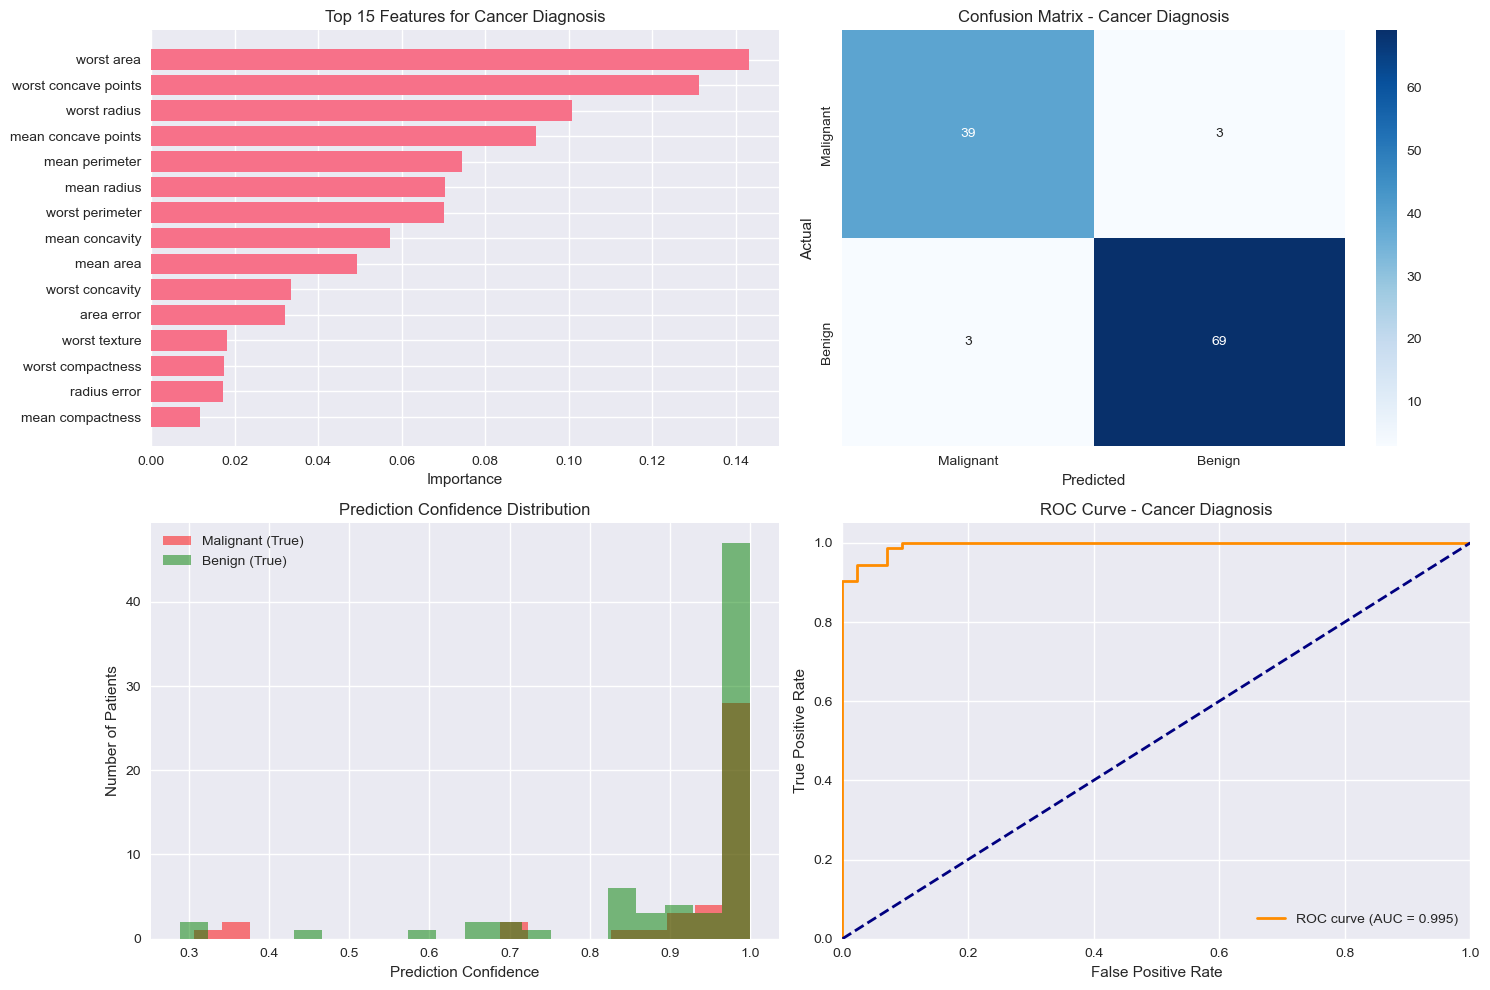


🏥 Clinical Interpretation:
Most important features for cancer diagnosis:
1. worst area: 0.143
2. worst concave points: 0.131
3. worst radius: 0.101
4. mean concave points: 0.092
5. mean perimeter: 0.074

Model Performance Summary:
• High accuracy    (94.7%) suitable for medical screening
• High sensitivity (95.8%) - good at detecting cancer
• ROC-AUC of 0.995 indicates excellent diagnostic ability
• Feature importance helps doctors understand key diagnostic indicators


In [ ]:
# Load breast cancer dataset for medical diagnosis example
print("🏥 Medical Diagnosis Example: Breast Cancer Classification")

cancer   = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print(f"Dataset             : {cancer.data.shape[0]} patients, {cancer.data.shape[1]} features")
print(f"Classes             : {cancer.target_names}")
print(f"Class distribution  : {np.bincount(y_cancer)}")

# Create feature DataFrame
cancer_df = pd.DataFrame(X_cancer, columns=cancer.feature_names)
cancer_df['diagnosis'] = y_cancer

print("\nFirst 5 patients:")
display(cancer_df.head())

# Split the data
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer)

# Train Random Forest for medical diagnosis
medical_rf = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_split=5,random_state=42,oob_score=True)

medical_rf.fit(X_train_cancer, y_train_cancer)

# Make predictions
y_pred_cancer  = medical_rf.predict(X_test_cancer)
y_proba_cancer = medical_rf.predict_proba(X_test_cancer)

print("\n🎯 Medical Diagnosis Results:")
print(f"Accuracy             : {accuracy_score(y_test_cancer, y_pred_cancer):.2f}")
print(f"Precision            : {precision_score(y_test_cancer, y_pred_cancer):.2f}")
print(f"Recall (Sensitivity) : {recall_score(y_test_cancer, y_pred_cancer):.2f}")
print(f"Specificity          : {confusion_matrix(y_test_cancer, y_pred_cancer)[0,0] / (confusion_matrix(y_test_cancer, y_pred_cancer)[0,0] + confusion_matrix(y_test_cancer, y_pred_cancer)[0,1]):.2f}")

# Feature importance for medical interpretation
medical_importance = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': medical_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n📊 Top 10 Most Important Features for Diagnosis:")
display(medical_importance.head(10))

# Visualize medical results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Feature importance
top_features = medical_importance.head(15)
axes[0, 0].barh(top_features['Feature'], top_features['Importance'])
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('Top 15 Features for Cancer Diagnosis')
axes[0, 0].invert_yaxis()

# 2. Confusion matrix
cm_cancer = confusion_matrix(y_test_cancer, y_pred_cancer)
sns.heatmap(cm_cancer, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_title('Confusion Matrix - Cancer Diagnosis')

# 3. Prediction confidence distribution
axes[1, 0].hist(y_proba_cancer[y_test_cancer == 0, 0], bins=20, alpha=0.5, label='Malignant (True)', color='red')
axes[1, 0].hist(y_proba_cancer[y_test_cancer == 1, 1], bins=20, alpha=0.5, label='Benign (True)', color='green')
axes[1, 0].set_xlabel('Prediction Confidence')
axes[1, 0].set_ylabel('Number of Patients')
axes[1, 0].set_title('Prediction Confidence Distribution')
axes[1, 0].legend()

# 4. ROC Curve
fpr, tpr, _ = roc_curve(y_test_cancer, y_proba_cancer[:, 1])
roc_auc = auc(fpr, tpr)

axes[1, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve - Cancer Diagnosis')
axes[1, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Clinical interpretation
print("\n🏥 Clinical Interpretation:")
print("Most important features for cancer diagnosis:")
for i, (_, row) in enumerate(medical_importance.head(5).iterrows()):
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.3f}")

print(f"\nModel Performance Summary:")
print(f"• High accuracy    ({accuracy_score(y_test_cancer, y_pred_cancer):.1%}) suitable for medical screening")
print(f"• High sensitivity ({recall_score(y_test_cancer, y_pred_cancer):.1%}) - good at detecting cancer")
print(f"• ROC-AUC of {roc_auc:.3f} indicates excellent diagnostic ability")
print(f"• Feature importance helps doctors understand key diagnostic indicators")

## **📝 14. Summary and Key Takeaways**

### **Random Forest in a Nutshell:** 🌰

Random Forest is a powerful ensemble method that combines multiple decision trees using bootstrap sampling and random feature selection to create more accurate and robust predictions than individual decision trees.

### **Key Concepts Learned:** 💡

1. **Ensemble Learning**: Combining multiple weak learners creates a strong learner
2. **Bootstrap Aggregating**: Reduces variance through averaging
3. **Random Feature Selection**: Reduces correlation between trees
4. **Out-of-Bag Validation**: Built-in cross-validation without separate test set
5. **Feature Importance**: Robust feature ranking across multiple trees
6. **Bias-Variance Tradeoff**: RF reduces variance while maintaining low bias

### **Key Hyperparameters:** 🎛️

1. **n_estimators**: Number of trees (more trees = better performance, diminishing returns)
2. **max_features**: Number of features per split ('sqrt' often works well)
3. **max_depth**: Maximum tree depth (controls overfitting)
4. **min_samples_split**: Minimum samples to split a node
5. **min_samples_leaf**: Minimum samples in leaf nodes
6. **oob_score**: Enable out-of-bag scoring for validation

### **Best Practices:** 🎯

1. **Start with Defaults**: Random Forest works well out-of-the-box
2. **Use OOB Score**: Leverage built-in validation for model selection
3. **Feature Importance**: Use for feature selection and interpretation
4. **Balance Trees**: More trees generally better, but diminishing returns after ~100
5. **Cross-Validate**: Always validate performance with cross-validation
6. **Consider Memory**: More trees = more memory usage

### **Performance Tips:** ⚡

- **Parallel Processing**: Set `n_jobs=-1` for faster training
- **Warm Start**: Use `warm_start=True` to add trees incrementally
- **Feature Engineering**: Good features still matter for RF performance
- **Class Imbalance**: Use `class_weight='balanced'` for imbalanced datasets

### **When to Use Random Forest:** ✅

- **Tabular Data**: Excellent for structured/tabular datasets
- **Mixed Data Types**: Handles numerical and categorical features
- **Feature Selection**: When you need feature importance
- **Robust Predictions**: When you need stable, reliable models
- **Baseline Models**: Strong baseline for comparison
- **Interpretability**: When you need some interpretability (via feature importance)

### **Comparison with Other Methods:**

| Method | Interpretability | Accuracy | Training Speed | Prediction Speed |
|--------|------------------|-----------|----------------|------------------|
| Decision Tree | ⭐⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| Random Forest | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐ |
| Linear Models | ⭐⭐⭐⭐ | ⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |

### **Next Steps:** 🚀

- **XGBoost**: Learn gradient boosting for even better performance
- **Feature Engineering**: Improve your features for better RF performance
- **Hyperparameter Tuning**: Use GridSearch or Bayesian optimization
- **Ensemble Methods**: Combine RF with other algorithms
- **Deep Learning**: Explore neural networks for complex patterns

Random Forest is often the "Swiss Army knife" of machine learning - reliable, robust, and effective across many different types of problems! 🌲✨